Цель проекта - выделить ключевые признаки рейса доставки, которые влияют на стоимость. Ранжировать их. Сформулировать правила доставки, которые помогут снизить % затрата на доставку.

План такой:
- Обработка данных, создание интуитивно правильных признаком по рейсам
- Разведывательный анализ
- Анализ на применимость линейной модели, т.к. желательно, чтобы модель получилась линейной
- Выбор метрик и моделирование
- Разбор результатов: выделение выбросов (максимальная ошибка моделирования) и их анализ
- Смотрим значимость признаков и даем рекомендации: какие действия могут наиболее сильно повлиять на % логистических затрат. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')

C:\Users\killr\AppData\Local\Temp\ipykernel_2844\771094940.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
df = pd.read_excel('data\Лога ШМТ_мод.xlsx')
df.head(2)

,Водитель,Дата,Часов,Ставка в час,Стоянка,Оплата,Общая сумма в машине,% в фуре,Месяц,Клиент,Рейс,Заказано,Lon,Lat,Доставка
0,Соколов П,2023-05-02,8.5,2500,550,21800,886470,0.008488,5,ЧЛ Три Самурая,1,7524,42.323816,69.575731,185.029612
1,Соколов П,2023-05-02,8.5,2500,550,21800,886470,0.011612,5,ЧЛ Сарыарка,1,10294,42.323363,69.594424,253.149232


In [4]:
trips = pd.pivot_table(data = df,index='Рейс', values=['Дата','Часов','Ставка в час','Стоянка','Оплата','Общая сумма в машине','Клиент','Заказано','Lon','Lat']
                       , aggfunc={'Дата':'max', 'Часов':'mean','Ставка в час':'mean','Стоянка':'mean','Оплата':'mean',
                                  'Общая сумма в машине':'mean','Клиент':'nunique','Заказано':'sum','Lon':'mean','Lat':'mean'})
trips['Средний чек'] = trips['Заказано'] / trips['Клиент']
trips.head(3)

,Lat,Lon,Дата,Заказано,Клиент,Общая сумма в машине,Оплата,Ставка в час,Стоянка,Часов,Средний чек
Рейс,,,,,,,,,,,
1,69.575209,42.328496,2023-05-02,886470,16,886470,21800,2500,550,8.5,55404.375000
2,69.624947,42.329333,2023-05-03,740788,7,740788,22850,2500,350,9.0,105826.857143
3,69.621522,42.316743,2023-05-04,387308,21,387308,24150,2500,400,9.5,18443.238095


In [5]:
#Создадим признаки связанные с расстоянием.
#Будем учитывать и расстояние по прямой 
#вычислим разброс точек и расстояние от точки погрузки до цента масс маршрута

In [6]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [7]:
lon_home = 42.315725 
lat_home = 69.550404

In [8]:
trips = trips.reset_index()

In [9]:
def set_trip_center_dist(trip):
    lat = trips[trips['Рейс'] == trip]['Lat'].iloc[0]
    lon = trips[trips['Рейс'] == trip]['Lon'].iloc[0]
    return get_haversine_distance(lat_home, lon_home, lat, lon)

trips['trip_center_dist'] = trips['Рейс'].apply(set_trip_center_dist)

In [10]:

def count_trip_std(trip_number):

    table = df[df['Рейс']==trip_number][['Lon','Lat']]

    dist_list = list()
    for i in table.index:
        lon1 = table.loc[i,'Lon']
        lat1 = table.loc[i,'Lat']
        for j in table.index:
            if j>i:
                lon2 = table.loc[j,'Lon']
                lat2 = table.loc[j,'Lat']
                dist_list.append(get_haversine_distance(lat1, lon1, lat2, lon2))
            
    return np.mean(dist_list)

In [11]:
trips['trip_std'] = trips['Рейс'].apply(count_trip_std)
trips.head(2)

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,Рейс,Lat,Lon,Дата,Заказано,Клиент,Общая сумма в машине,Оплата,Ставка в час,Стоянка,Часов,Средний чек,trip_center_dist,trip_std
0,1,69.575209,42.328496,2023-05-02,886470,16,886470,21800,2500,550,8.5,55404.375000,2.802388,4.895896
1,2,69.624947,42.329333,2023-05-03,740788,7,740788,22850,2500,350,9.0,105826.857143,8.305539,2.685086


In [12]:
trips['Логистика %'] = trips['Оплата'] / trips['Заказано']
trips.head(2)

,Рейс,Lat,Lon,Дата,Заказано,Клиент,Общая сумма в машине,Оплата,Ставка в час,Стоянка,Часов,Средний чек,trip_center_dist,trip_std,Логистика %
0,1,69.575209,42.328496,2023-05-02,886470,16,886470,21800,2500,550,8.5,55404.375000,2.802388,4.895896,0.024592
1,2,69.624947,42.329333,2023-05-03,740788,7,740788,22850,2500,350,9.0,105826.857143,8.305539,2.685086,0.030846


In [13]:
trips= trips.drop(['Lat','Lon'], axis=1)

## Разведывательный анализ

### Распределение признаков

In [14]:
features = ['Заказано','Клиент', 'Общая сумма в машине', 'Оплата','Ставка в час', 'Стоянка', 'Часов', 'Средний чек', 'trip_center_dist', 'trip_std', 'Логистика %']

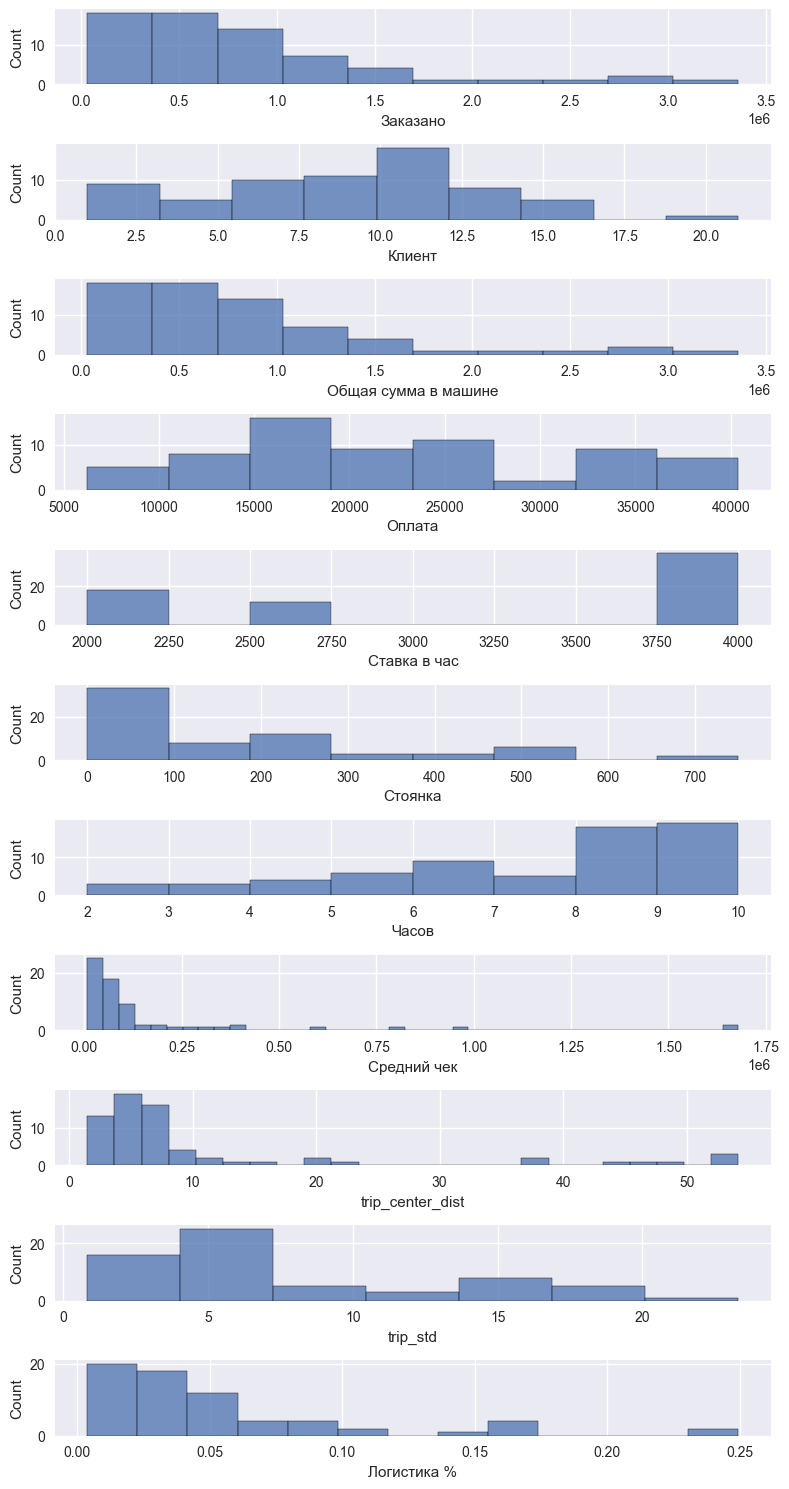

In [15]:
fig, axes = plt.subplots(len(features),1, figsize=(8,15))

for i, feature in enumerate(features):
    sns.histplot(trips[feature], ax= axes[i])

plt.tight_layout()

### Совместное распределение признаков с целевым

In [16]:
trips = trips.drop(['Заказано'], axis=1)

<AxesSubplot: xlabel='Общая сумма в машине', ylabel='Логистика %'>

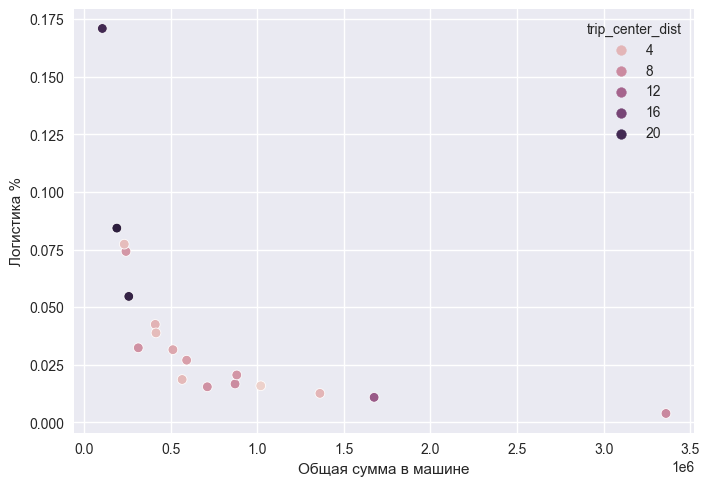

In [28]:
sns.scatterplot(trips[trips['Ставка в час']==2000], x='Общая сумма в машине', y='Логистика %', hue='trip_center_dist')

C:\Users\killr\AppData\Local\Temp\ipykernel_2844\3694888050.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(trips.corr(), annot=True, fmt='.2f')


<AxesSubplot: >

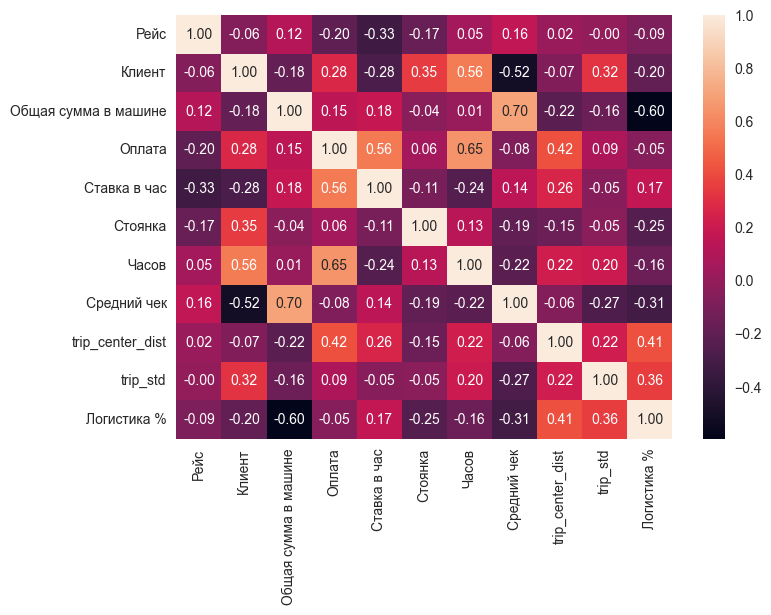

In [18]:
sns.heatmap(trips.corr(), annot=True, fmt='.2f')


In [19]:
trips.sort_values(by='Общая сумма в машине', ascending=False).tail(10)

,Рейс,Дата,Клиент,Общая сумма в машине,Оплата,Ставка в час,Стоянка,Часов,Средний чек,trip_center_dist,trip_std,Логистика %
4,5,2023-05-06,9,184454,10150,2500,150,4.0,20494.888889,7.189705,4.108307,0.055027
11,12,2023-05-18,6,179765,6250,2500,0,2.5,29960.833333,1.788219,6.121684,0.034768
35,36,2023-06-08,10,162209,26000,4000,0,6.5,16220.900000,15.100907,14.405895,0.160287
3,4,2023-05-05,5,152364,23750,2500,0,9.5,30472.800000,5.837563,10.019912,0.155877
48,49,2023-06-29,5,120337,18000,4000,0,4.5,24067.400000,3.351151,6.340354,0.149580
31,32,2023-06-02,7,111335,12000,4000,0,3.0,15905.000000,5.866207,17.547184,0.107783
55,56,2023-06-16,8,106195,18150,2000,150,9.0,13274.375000,20.146660,16.242479,0.170912
27,28,2023-05-15,1,71752,12000,4000,0,3.0,71752.000000,37.826794,NaN,0.167243
29,30,2023-05-25,1,66836,16000,4000,0,4.0,66836.000000,37.826794,NaN,0.239392
13,14,2023-05-03,4,32055,8000,4000,0,2.0,8013.750000,10.354505,13.264862,0.249571


In [20]:
trips[(trips['trip_center_dist']>30) &(trips['Оплата']<30000)]

,Рейс,Дата,Клиент,Общая сумма в машине,Оплата,Ставка в час,Стоянка,Часов,Средний чек,trip_center_dist,trip_std,Логистика %
27,28,2023-05-15,1,71752,12000,4000,0,3.0,71752.0,37.826794,NaN,0.167243
29,30,2023-05-25,1,66836,16000,4000,0,4.0,66836.0,37.826794,NaN,0.239392


In [21]:
df[df['Рейс'] == 30]	

,Водитель,Дата,Часов,Ставка в час,Стоянка,Оплата,Общая сумма в машине,% в фуре,Месяц,Клиент,Рейс,Заказано,Lon,Lat,Доставка
273,Наемный,2023-05-25,4.0,4000,0,16000,66836,1.0,5,ТОО ALMA-TAU,30,66836,42.183116,69.887469,16000.0


In [22]:
df[df['Клиент'] == 'ТОО ALMA-TAU']	

,Водитель,Дата,Часов,Ставка в час,Стоянка,Оплата,Общая сумма в машине,% в фуре,Месяц,Клиент,Рейс,Заказано,Lon,Lat,Доставка
270,Наемный,2023-05-15,3.0,4000,0,12000,71752,1.0,5,ТОО ALMA-TAU,28,71752,42.183116,69.887469,12000.0
273,Наемный,2023-05-25,4.0,4000,0,16000,66836,1.0,5,ТОО ALMA-TAU,30,66836,42.183116,69.887469,16000.0


In [23]:
client_coord = df.groupby('Клиент', as_index=False)[['Lat','Lon']].mean()


In [24]:
get_haversine_distance(lat_home, lon_home, 69.887469, 42.183116)

37.826794328405214

In [25]:
def set_client_dist(client):
    lat = client_coord[client_coord['Клиент'] == client]['Lat'].iloc[0]
    lon = client_coord[client_coord['Клиент'] == client]['Lon'].iloc[0]
    return get_haversine_distance(lat_home, lon_home, lat, lon)



client_coord['dist'] = client_coord['Клиент'].apply(set_client_dist)

In [26]:
client_coord.sort_values(by='dist', ascending=False).head(10)
client_coord.to_excel('distances.xlsx')